# Proyek Akhir : Image Classification Model Deployment


# Import Library

In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 102.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 111.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: ml_dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found ex

In [2]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from collections import Counter

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.19.0


# Data Loading

In [4]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"agummedisa","key":"9f9c539f8524888cdbe91d65af6c4211"}'}

In [5]:
!mkdir ~/.kaggle/

!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.jsonyrd

!kaggle datasets download -d bhaveshmittal/multi-class-rice-image-dataset

!unzip multi-class-rice-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Validation/Jasmine/10001.jpg  
  inflating: Validation/Jasmine/10002.jpg  
  inflating: Validation/Jasmine/10003.jpg  
  inflating: Validation/Jasmine/10004.jpg  
  inflating: Validation/Jasmine/10005.jpg  
  inflating: Validation/Jasmine/10006.jpg  
  inflating: Validation/Jasmine/10007.jpg  
  inflating: Validation/Jasmine/10008.jpg  
  inflating: Validation/Jasmine/10009.jpg  
  inflating: Validation/Jasmine/10010.jpg  
  inflating: Validation/Jasmine/10011.jpg  
  inflating: Validation/Jasmine/10012.jpg  
  inflating: Validation/Jasmine/10013.jpg  
  inflating: Validation/Jasmine/10014.jpg  
  inflating: Validation/Jasmine/10015.jpg  
  inflating: Validation/Jasmine/10016.jpg  
  inflating: Validation/Jasmine/10017.jpg  
  inflating: Validation/Jasmine/10018.jpg  
  inflating: Validation/Jasmine/10019.jpg  
  inflating: Validation/Jasmine/10020.jpg  
  inflating: Validation/Jasmine/10021.jpg  
  inflating: Validation/J

# Data Preparation

In [6]:
# Direktori awal untuk train dan test
train_dir = "/content/Train" #Fixed path
test_dir = "/content/Test" #Fixed path
val_dir = "/content/Validation" #Fixed path


# Direktori baru untuk dataset gabungan
combined_dir = "rice/dataset"
os.makedirs(combined_dir, exist_ok=True)

In [7]:
# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        # copy the content only to the combined_dir with category as subfolder
        # the source directory has an extra subfolder named as the category
        # e.g. Train/Arborio/Arborio, hence the path slicing
        # Fixed: Removing extra subfolder level in source path
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        # copy the content only to the combined_dir with category as subfolder
        # the source directory has an extra subfolder named as the category
        # e.g. Train/Arborio/Arborio, hence the path slicing
        # Fixed: Removing extra subfolder level in source path
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

for category in os.listdir(val_dir):
    category_dir = os.path.join(val_dir, category)
    if os.path.isdir(category_dir):
        # copy the content only to the combined_dir with category as subfolder
        # the source directory has an extra subfolder named as the category
        # e.g. Train/Arborio/Arborio, hence the path slicing
        # Fixed: Removing extra subfolder level in source path
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Dataset Checking

{'Arborio': ['10540.jpg', '10781.jpg', '10188.jpg', '1319.jpg', '4573.jpg', '3344.jpg', '4320.jpg', '1476.jpg', '3920.jpg', '6580.jpg', '6348.jpg', '2243.jpg', '11946.jpg', '5157.jpg', '11849.jpg', '10946.jpg', '7847.jpg', '1160.jpg', '3893.jpg', '8860.jpg', '2835.jpg', '13810.jpg', '9814.jpg', '237.jpg', '11565.jpg', '6465.jpg', '1707.jpg', '5506.jpg', '12522.jpg', '3505.jpg', '1478.jpg', '1554.jpg', '8145.jpg', '9607.jpg', '2712.jpg', '8087.jpg', '378.jpg', '8751.jpg', '7418.jpg', '12428.jpg', '8596.jpg', '3296.jpg', '10738.jpg', '2458.jpg', '10245.jpg', '6898.jpg', '11442.jpg', '11129.jpg', '13796.jpg', '11087.jpg', '13329.jpg', '9209.jpg', '11679.jpg', '3885.jpg', '11056.jpg', '10596.jpg', '5402.jpg', '2547.jpg', '7760.jpg', '8946.jpg', '4495.jpg', '7852.jpg', '283.jpg', '11759.jpg', '6830.jpg', '52.jpg', '6533.jpg', '8634.jpg', '7552.jpg', '11354.jpg', '6736.jpg', '12833.jpg', '2549.jpg', '13610.jpg', '14390.jpg', '12913.jpg', '20.jpg', '8440.jpg', '13452.jpg', '11736.jpg', '1921.

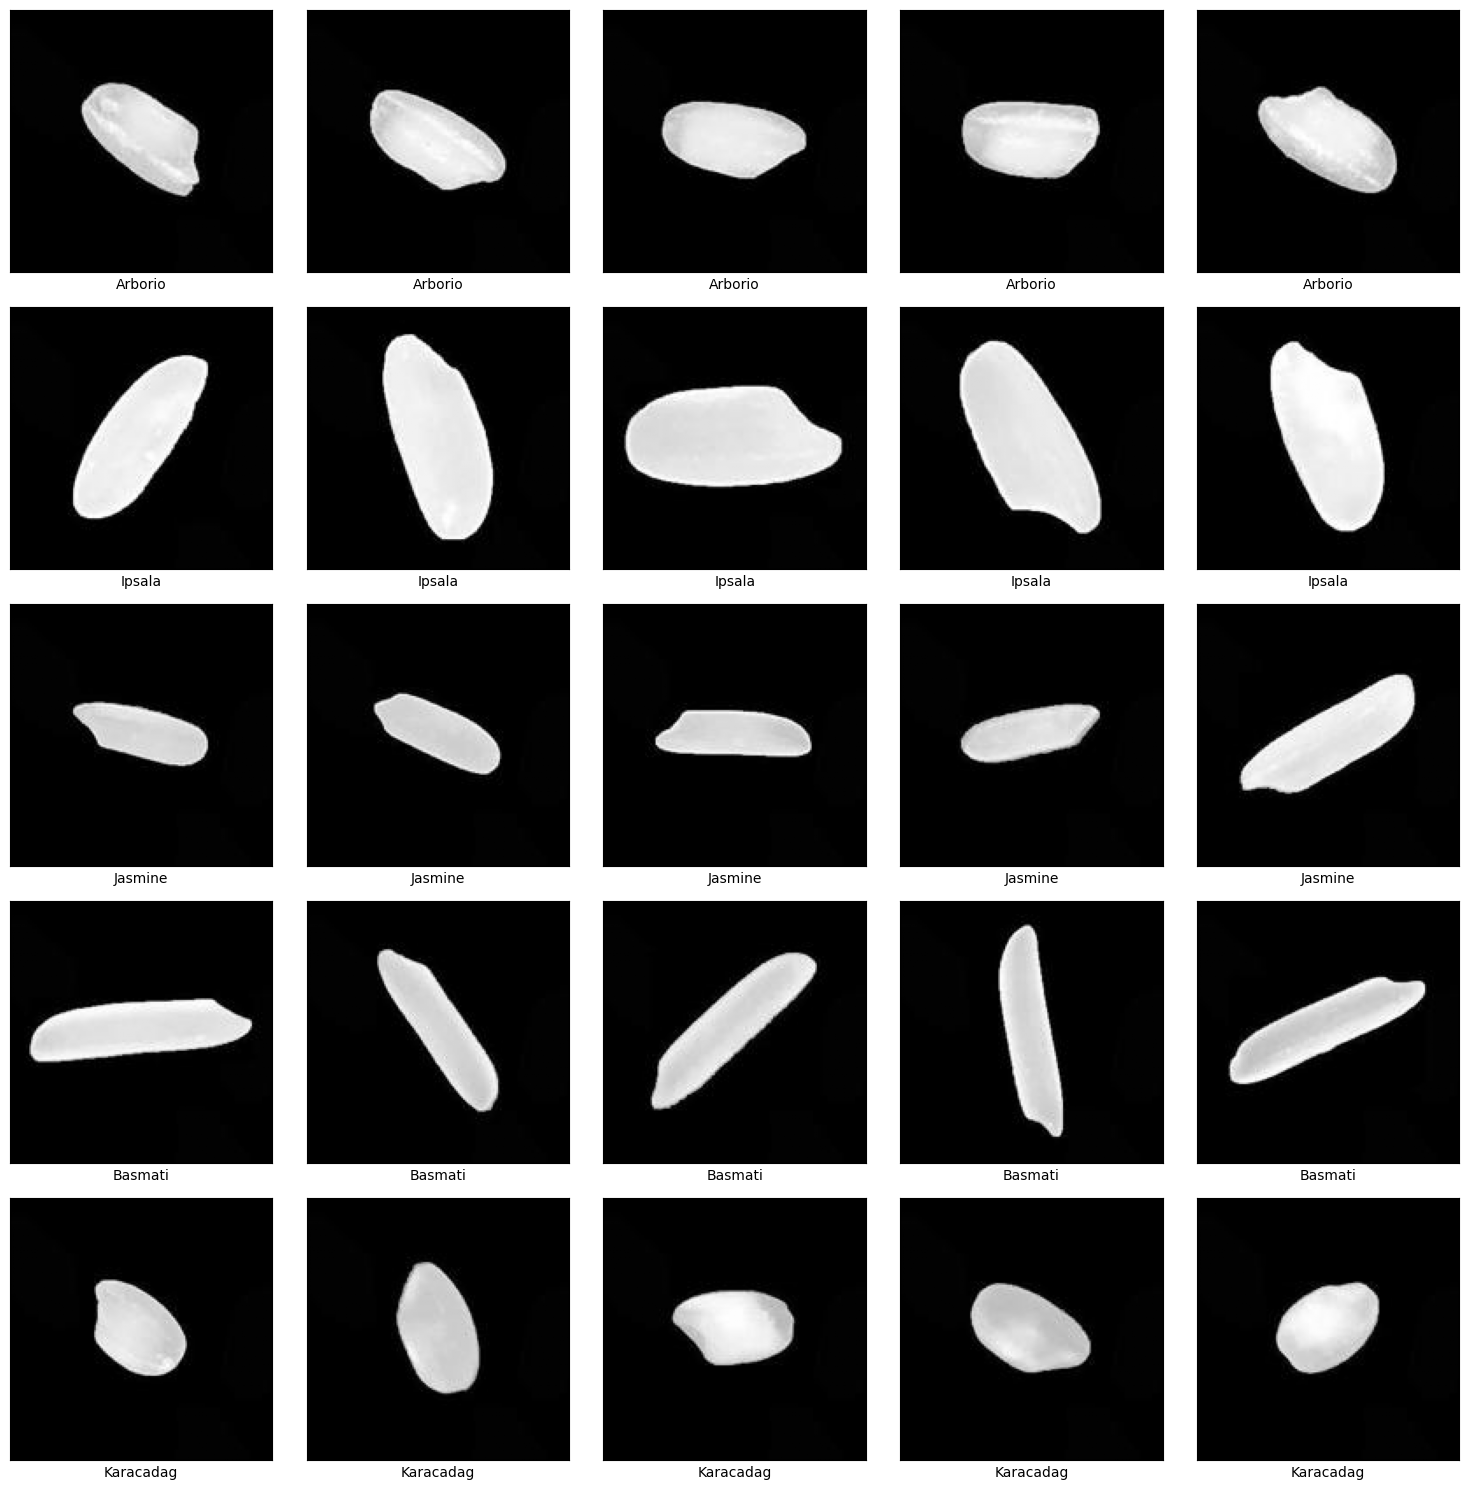

In [8]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
rice_image = {}

# Tentukan path sumber train
path = "rice/"
path_sub = os.path.join(path, "dataset")

# Memastikan path_sub ada
if not os.path.exists(path_sub):
    print(f"Error: Directory '{path_sub}' not found.")
else:
    for i in os.listdir(path_sub):
        class_path = os.path.join(path_sub, i)
        if os.path.isdir(class_path): #memastikan yang di proses adalah direktori
            rice_image[i] = os.listdir(class_path)

    print(rice_image) #mengecek isi dari rice_image

    # Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
    if rice_image: #memastikan rice_image tidak kosong
        fig, axs = plt.subplots(len(rice_image.keys()), 5, figsize=(15, 15))

        for i, class_name in enumerate(rice_image.keys()):
            images = np.random.choice(rice_image[class_name], 5, replace=False)

            for j, image_name in enumerate(images):
                img_path = os.path.join(path_sub, class_name, image_name)
                img = Image.open(img_path).convert("L")  # Konversi menjadi skala keabuan
                axs[i, j].imshow(img, cmap='gray')
                axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

        fig.tight_layout()
        plt.show()
    else:
        print("Error: No classes found in the dataset directory.")

# Plot Distribusi

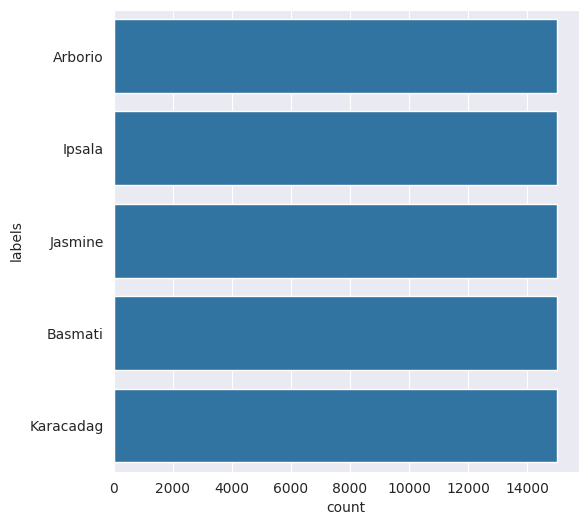

In [9]:
# Definisikan path sumber
lung_path = "rice/dataset/"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

**Insight:**
- Jumlah data semuanya sama, saya rasa tidak perlu masuk ke tahap **Data Augmentation**

# Data Splitting

In [10]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'rice/dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
Arborio,15000
Basmati,15000
Ipsala,15000
Jasmine,15000
Karacadag,15000


In [11]:
# Variabel yang digunakan pada pemisahan data ini di mana variabel x = data path dan y = data labels

X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [12]:
# Menyatukan ke dalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})
df_va = pd.DataFrame({'path':X_test,'labels':y_test,'set':'val'})

In [13]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te, df_va], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "rice/dataset/"
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"


set    labels   
test   Arborio       3026
       Basmati       2983
       Ipsala        2963
       Jasmine       3040
       Karacadag     2988
train  Arborio      11974
       Basmati      12017
       Ipsala       12037
       Jasmine      11960
       Karacadag    12012
val    Arborio       3026
       Basmati       2983
       Ipsala        2963
       Jasmine       3040
       Karacadag     2988
dtype: int64 


                                  path     labels    set
63223   rice/dataset/Jasmine/13353.jpg    Jasmine   test
31545  rice/dataset/Karacadag/9018.jpg  Karacadag  train
19365    rice/dataset/Arborio/8168.jpg    Arborio  train
68190    rice/dataset/Basmati/1141.jpg    Basmati   test
17376    rice/dataset/Jasmine/2768.jpg    Jasmine  train


In [14]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

# Image Data Generator

In [15]:
# Definisikan direktori training, validasi, dan test
TRAIN_DIR = "Dataset-Final/train"
TEST_DIR = "Dataset-Final/test"
VAL_DIR = "Dataset-Final/val"

# Fungsi untuk menghitung total gambar dalam semua subfolder
def count_images(directory):
    total_images = 0
    for category in os.listdir(directory):  # Iterasi setiap folder kategori
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):  # Pastikan ini folder, bukan file
            total_images += len(os.listdir(category_path))  # Hitung jumlah file dalam folder
    return total_images

# Hitung jumlah gambar di masing-masing dataset
total_train_images = count_images(TRAIN_DIR)
total_test_images = count_images(TEST_DIR)
total_val_images = count_images(VAL_DIR)

# Cetak hasil
print("Total number of images in training set: ", total_train_images)
print("Total number of images in test set: ", total_test_images)
print("Total number of images in validation set: ", total_val_images)


Total number of images in training set:  60000
Total number of images in test set:  15000
Total number of images in validation set:  15000


In [16]:
# Create an ImageDataGenerator object normalizing the images
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="grayscale",
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(VAL_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                   color_mode="grayscale",
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="grayscale",
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 48002 images belonging to 5 classes.
Found 2998 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.


In [17]:
# Cek distribusi kelas di training set
import numpy as np
class_counts = np.bincount(train_generator.classes)
print("Distribusi per kelas:", class_counts)

Distribusi per kelas: [9580 9614 9630 9568 9610]


**Insight:**
- Karena distribusi per kelas dapat disebut seimbang, maka nanti tidak perlu class weight

## Skema CNN Architecture dengan 128 Neurons pada Conv Layer

In [18]:
# Bersihkan sesi sebelumnya
tf.keras.backend.clear_session()

# Ambil jumlah kelas dari dataset (misalnya 5: Arborio, Basmati, Ipsala, Jasmine, Karacadag)
num_classes = 5

####################### Init sequential model ##################################
model_1 = Sequential()

# 1st Convolutional layer
model_1.add(Conv2D(128, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 2nd Convolutional layer
model_1.add(Conv2D(64, (4, 4), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 3rd Convolutional layer
model_1.add(Conv2D(128, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# Flatten layer
model_1.add(Flatten())

# Fully Connected Layers
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(64, activation='relu'))
model_1.add(Dropout(0.3))

# Final Dense layer => Softmax untuk multi-class classification
model_1.add(Dense(num_classes, activation='softmax'))

######################### Compile Model ################################
model_1.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='categorical_crossentropy',  # Ubah ke categorical crossentropy
                metrics=['accuracy'])

# Summary of the Model Architecture
print(model_1.summary())


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 128)       │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       5,308,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,852,357 (22.32 MB)

 Trainable params: 5,851,717 (22.32 MB)

 Non-trainable params: 640 (2.50 KB)

None


In [21]:
# Callback untuk menghentikan training jika akurasi lebih dari 85% pada training dan testing set
class StopTrainingOnAccuracy(Callback):
    def __init__(self, train_data, test_data, target_accuracy=0.85):
        super(StopTrainingOnAccuracy, self).__init__()
        self.train_data = train_data
        self.test_data = test_data
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        # Mengecek akurasi pada training set
        train_loss, train_accuracy = self.model.evaluate(self.train_data, verbose=0)
        print(f"Epoch {epoch + 1}: Akurasi Training = {train_accuracy * 100:.2f}%")

        # Mengecek akurasi pada testing set
        test_loss, test_accuracy = self.model.evaluate(self.test_data, verbose=0)
        print(f"Epoch {epoch + 1}: Akurasi Testing = {test_accuracy * 100:.2f}%")

        # Hentikan training jika akurasi pada kedua set lebih dari target_accuracy
        if train_accuracy >= self.target_accuracy and test_accuracy >= self.target_accuracy:
            print(f"\nAkurasi Training dan Testing sudah lebih dari {self.target_accuracy * 100}%, training dihentikan.")
            self.model.stop_training = True

# Turunkan learning rate jika loss tidak membaik
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,  # Turunkan learning rate 50%
    patience=3,  # Tunggu 3 epoch sebelum menurunkan LR
    verbose=1
)

# Hentikan training jika model stagnan
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,  # Berhenti setelah 5 epoch tanpa peningkatan
    restore_best_weights=True,  # Kembalikan model ke versi terbaik
    verbose=1
)

# Callback untuk stop training ketika akurasi >= 85% pada training dan testing set
stop_on_accuracy = StopTrainingOnAccuracy(train_data=train_generator, test_data=validation_generator, target_accuracy=0.85)

# Gabungkan semua callback
callbacks = [lr_scheduler, early_stopping, stop_on_accuracy]

# Training model tanpa class weights
history = model_1.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3652 - loss: 1.2793Epoch 1: Akurasi Training = 38.91%
Epoch 1: Akurasi Testing = 38.73%
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 163s 108ms/step - accuracy: 0.3652 - loss: 1.2793 - val_accuracy: 0.3873 - val_loss: 1.1603 - learning_rate: 0.0010
Epoch 2/30
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3770 - loss: 1.2446Epoch 2: Akurasi Training = 41.47%
Epoch 2: Akurasi Testing = 39.23%
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 162s 108ms/step - accuracy: 0.3770 - loss: 1.2446 - val_accuracy: 0.3923 - val_loss: 1.1551 - learning_rate: 0.0010
Epoch 3/30
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3858 - loss: 1.2219Epoch 3: Akurasi Training = 52.07%
Epoch 3: Akurasi Testing = 50.50%
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 201s 108ms/step - accuracy: 0.3858 - loss: 1.2219 - val_accuracy: 0.5050 - val_loss: 1.0807 - learning_rate: 0.0010
Epoch 4/30
1501/1501 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.4505 - loss: 1.1766

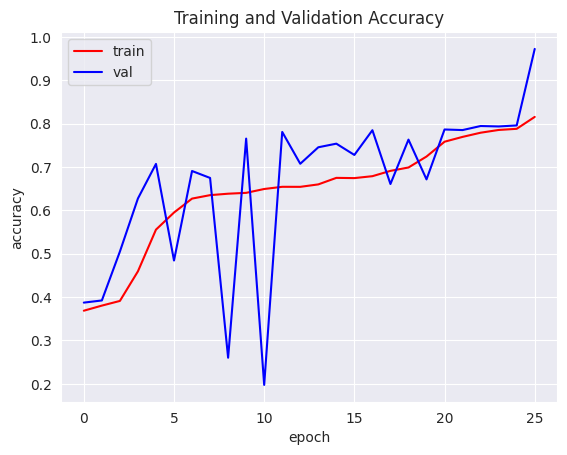

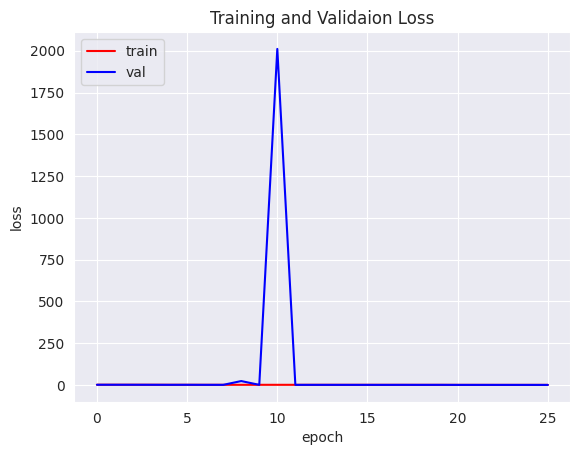

In [22]:
acc = history.history['accuracy'] # Changed history_final to history
val_acc = history.history['val_accuracy'] # Changed history_final to history
loss = history.history['loss'] # Changed history_final to history
val_loss = history.history['val_loss'] # Changed history_final to history

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

In [23]:
# Simpan model ke dalam format SavedModel
tf.saved_model.save(model_1, 'saved_model')

# Konversi model ke format TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model_1)
tflite_model = converter.convert()

# Simpan model TF-Lite
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)


# Simpan model dalam format yang dapat dijalankan di browser
tfjs.converters.save_keras_model(model_1, 'tfjs_model')


Saved artifact at '/tmp/tmpj57s80ou'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  137125165665936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137125165672464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137125165673616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137125165674960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137125165674768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137125165673040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137125165675536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137125165676304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137125165676688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137125165678416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13712516567592

failed to lookup keras version from the file,
    this is likely a weight only file


# Interface Model dengan Keras 3

In [24]:
from google.colab import files
import io
import numpy as np
import tensorflow as tf
from PIL import Image
import keras

# Upload gambar
uploaded = files.upload()

for fn in uploaded.keys():
    # Buka gambar dan ubah ke grayscale
    img = Image.open(io.BytesIO(uploaded[fn])).convert("L")
    img = img.resize((150, 150))

    # Ubah ke numpy array dan normalisasi
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Tambah batch dimension
    img_array = np.expand_dims(img_array, axis=-1) # Tambah channel grayscale

    # Load model dari format SavedModel menggunakan TFSMLayer
    model_path = "saved_model"
    model = keras.layers.TFSMLayer(model_path, call_endpoint="serving_default")

    # Lakukan inferensi
    prediction = model(img_array)

    # Ambil kelas dengan probabilitas tertinggi
    predicted_class = np.argmax(prediction)

    # Label kelas (ganti sesuai dataset)
    class_labels = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]
    predicted_label = class_labels[predicted_class]

    print("Predicted Label:", predicted_label)


Saving gliaironi_cucchiaio_arborio-zoom.jpg to gliaironi_cucchiaio_arborio-zoom.jpg
Predicted Label: Arborio


In [26]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
!cp -r /content/saved_model /content/drive/MyDrive/
!cp -r /content/tfjs_model /content/drive/MyDrive/


In [28]:
pip freeze > requirements.txt